In [1]:
%reload_kedro

[01/26/25 11:23:15] INFO     Resolved project path as:                                              ]8;id=439560;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=481118;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py#178\178]8;;\
                             C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales.                 
                             To set a different path, run '%reload_kedro <project_root>'                           

[01/26/25 11:23:18] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=128926;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=325514;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro_telemetry\plugin.py#233\233]8;;\
                             the product. No personal data or IP addresses are stored on our side. If              
                             you want to opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK`              
                             environment variables, or create a `.telemetry` file in the current                   
                             working directory with the contents `consent: false`. Read more at                    
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[01/26/25 11:23:19] INFO     Kedro project forecasting-sticker-sales                                ]8;id=75971;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=317050;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py#144\144]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=609962;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=529130;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py#145\145]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=91622;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=220479;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py#151\151]8;;\

In [32]:
import optuna
import lightgbm as lgb
from pyspark.sql.functions import col, year, month, dayofmonth, dayofweek, when
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
train_df = catalog.load("train")

[01/26/25 11:24:28] INFO     Loading data from train (SparkDataset)...                          ]8;id=944905;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=438972;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\io\data_catalog.py#389\389]8;;\

In [6]:
test_df = catalog.load("test")

[01/26/25 11:24:32] INFO     Loading data from test (SparkDataset)...                           ]8;id=318287;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=999714;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\io\data_catalog.py#389\389]8;;\

In [14]:
def preprocess_data(df):
    df = df.withColumn('year', year(col('date'))) \
        .withColumn('month', month(col('date'))) \
        .withColumn('day', dayofmonth(col('date'))) \
        .withColumn('day_of_week', dayofweek(col('date'))) \
        .withColumn('is_weekend', when(col('day_of_week') >= 6, 1).otherwise(0))
    return df

In [35]:
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'mape',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)
    }

    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    model = lgb.train(param, dtrain, valid_sets=[dval], callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)])

    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    mape = mean_absolute_percentage_error(y_val, y_pred)

    return mape

In [38]:
# Preprocess the data
train_df = preprocess_data(train_df)

# Convert to Pandas DataFrame for compatibility with LightGBM and Optuna
train_pd = train_df.toPandas()

# Handle missing values by filling them with zeros or another strategy
train_pd.fillna(0, inplace=True)

# Encode categorical features
label_encoders = {}
for column in ['country', 'store', 'product']:
    le = LabelEncoder()
    train_pd[column] = le.fit_transform(train_pd[column])
    label_encoders[column] = le

# Define features and target
features = ['country', 'store', 'product', 'year', 'month', 'day', 'day_of_week', 'is_weekend']
target = 'num_sold'

X = train_pd[features]
y = train_pd[target]

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

[01/26/25 11:39:26] WARNING  C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\. ]8;id=496835;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=739470;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             venv\lib\site-packages\pyspark\sql\pandas\conversion.py:111:                          
                             UserWarning: toPandas attempted Arrow optimization because                            
                             'spark.sql.execution.arrow.pyspark.enabled' is set to true; however,                  
                             failed by the reason below:                                                           
                               PyArrow >= 4.0.0 must be installed; however, it was not found.                      
                             Attempting non-optimization as                                                        
                             'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.                  
                               warn(msg)                                                                           
                                                                                                                   

In [39]:
# Create a study object and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=600)

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
best_params['n_estimators'] = 1000

final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X, y)

[I 2025-01-26 11:39:30,998] A new study created in memory with name: no-name-c488f12c-ec4f-499e-b188-32816e63bfcb


[01/26/25 11:39:31] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=147406;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=481706;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=882266;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=710871;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=251936;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=883141;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=434971;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=695816;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=33820;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=464577;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:39:32,389] Trial 0 finished with value: 1.0696752658255429e+17 and parameters: {'learning_rate': 0.0020669046673901163, 'num_leaves': 188, 'max_depth': 6, 'min_child_samples': 72, 'subsample': 0.5693161382888741, 'colsample_bytree': 0.579317132634004, 'reg_alpha': 0.10024754105561087, 'reg_lambda': 0.036819955404376}. Best is trial 0 with value: 1.0696752658255429e+17.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's mape: 30.9737
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 30.9737


[01/26/25 11:39:32] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=390666;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=36632;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=752208;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=632924;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=219898;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=220013;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=806085;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=300652;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=748842;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=713807;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 22.5556


[I 2025-01-26 11:39:33,597] Trial 1 finished with value: 5.0506782982761176e+16 and parameters: {'learning_rate': 0.009761901672067187, 'num_leaves': 36, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.945711473880862, 'colsample_bytree': 0.9559575560137179, 'reg_alpha': 0.018821410499488454, 'reg_lambda': 0.8595143294364995}. Best is trial 1 with value: 5.0506782982761176e+16.


[100]	valid_0's mape: 14.3775
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 14.3775


[01/26/25 11:39:33] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=394240;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=574625;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=713970;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=161616;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=934618;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=472855;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=995408;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=399704;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=319639;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=725577;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's mape: 29.7366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-01-26 11:39:35,435] Trial 2 finished with value: 8.37594293911435e+16 and parameters: {'learning_rate': 0.005385538680323248, 'num_leaves': 77, 'max_depth': 7, 'min_child_samples': 99, 'subsample': 0.6090489010904577, 'colsample_bytree': 0.6547092572922816, 'reg_alpha': 0.25930211362758826, 'reg_lambda': 0.2192210056916291}. Best is trial 1 with value: 5.0506782982761176e+16.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's mape: 24.3815
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 24.3815


[01/26/25 11:39:35] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=500454;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=915411;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=32143;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=722439;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=895060;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=484374;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=291068;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=403742;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=705486;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=642377;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:39:36,443] Trial 3 finished with value: 3.860375972808284e+16 and parameters: {'learning_rate': 0.013817515264978234, 'num_leaves': 246, 'max_depth': 4, 'min_child_samples': 48, 'subsample': 0.5596316816324307, 'colsample_bytree': 0.9228401200079289, 'reg_alpha': 1.5735087508466228, 'reg_lambda': 0.16771560146625972}. Best is trial 3 with value: 3.860375972808284e+16.


[01/26/25 11:39:36] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=295197;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=615796;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=666900;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=641881;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=460834;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=628720;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=270061;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=189167;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=75244;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=494269;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:39:37,836] Trial 4 finished with value: 6075416774474601.0 and parameters: {'learning_rate': 0.05408072645908728, 'num_leaves': 245, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.9868691296089027, 'colsample_bytree': 0.9324230603656858, 'reg_alpha': 0.7602133039369243, 'reg_lambda': 0.2756671126232087}. Best is trial 4 with value: 6075416774474601.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's mape: 1.68823
Did not meet early stopping. Best iteration is:
[88]	valid_0's mape: 1.67786


[01/26/25 11:39:37] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=83536;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=740901;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=781205;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=942254;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=473383;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=298886;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=754494;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=942125;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=282178;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=926108;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 29.6184


[I 2025-01-26 11:39:39,449] Trial 5 finished with value: 8.433909100144098e+16 and parameters: {'learning_rate': 0.004286800580109254, 'num_leaves': 34, 'max_depth': 6, 'min_child_samples': 43, 'subsample': 0.9222865108783108, 'colsample_bytree': 0.8346364362484673, 'reg_alpha': 0.375914091936653, 'reg_lambda': 0.01355453923503616}. Best is trial 4 with value: 6075416774474601.0.


[100]	valid_0's mape: 24.4119
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 24.4119


[01/26/25 11:39:39] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=483801;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=556361;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=924999;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=269889;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=634323;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=392649;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=76223;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=327666;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=401941;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=932179;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:39:40,477] Trial 6 finished with value: 1.8074977465687108e+16 and parameters: {'learning_rate': 0.025006486728632652, 'num_leaves': 284, 'max_depth': 4, 'min_child_samples': 82, 'subsample': 0.8777351952573997, 'colsample_bytree': 0.9550277036416341, 'reg_alpha': 1.582218391933365, 'reg_lambda': 0.04132632682583956}. Best is trial 4 with value: 6075416774474601.0.


[01/26/25 11:39:40] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=39567;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=33046;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=820441;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=192983;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=179369;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=439144;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=317987;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=630331;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=821018;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=912888;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:39:42,240] Trial 7 finished with value: 9.440139550363419e+16 and parameters: {'learning_rate': 0.0033672649639381355, 'num_leaves': 179, 'max_depth': 6, 'min_child_samples': 41, 'subsample': 0.8419583711277883, 'colsample_bytree': 0.6922872965592102, 'reg_alpha': 0.016914003484953814, 'reg_lambda': 0.2328031241403082}. Best is trial 4 with value: 6075416774474601.0.


[01/26/25 11:39:42] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=165469;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=548001;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=786032;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=945848;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=856393;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=242941;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=860784;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=417604;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=272067;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=134879;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:39:43,942] Trial 8 finished with value: 4.66513458034831e+16 and parameters: {'learning_rate': 0.011224888732936854, 'num_leaves': 137, 'max_depth': 4, 'min_child_samples': 51, 'subsample': 0.7046280431856342, 'colsample_bytree': 0.9772964347346966, 'reg_alpha': 3.0668340343292346, 'reg_lambda': 1.4333197479984205}. Best is trial 4 with value: 6075416774474601.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's mape: 13.2417
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 13.2417


[01/26/25 11:39:43] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=234967;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=328781;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=689665;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=440213;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=446278;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=58934;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=281801;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=900441;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=106728;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=527728;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-01-26 11:39:45,382] Trial 9 finished with value: 6.2888313584883784e+16 and parameters: {'learning_rate': 0.008420026762796403, 'num_leaves': 26, 'max_depth': 3, 'min_child_samples': 87, 'subsample': 0.815707683720547, 'colsample_bytree': 0.8832643420430359, 'reg_alpha': 3.888005156213025, 'reg_lambda': 0.9800535395784858}. Best is trial 4 with value: 6075416774474601.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's mape: 18.0297
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 18.0297


[01/26/25 11:39:45] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=512227;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=451073;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=899761;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=576542;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=809177;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=743835;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=699430;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=804205;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=539652;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=8442;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's mape: 1.76818
[100]	valid_0's mape: 0.899503
Did not meet early stopping. Best iteration is:
[99]	valid_0's mape: 0.899155


[I 2025-01-26 11:39:49,655] Trial 10 finished with value: 3331636840878427.5 and parameters: {'learning_rate': 0.08949571718068641, 'num_leaves': 242, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.9883234488765473, 'colsample_bytree': 0.7904892505712635, 'reg_alpha': 8.682635957736746, 'reg_lambda': 6.8816939562086645}. Best is trial 10 with value: 3331636840878427.5.


[01/26/25 11:39:49] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=685585;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=556860;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=278891;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=444645;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=67733;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=548282;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=549547;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=849203;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=856689;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=520939;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.64768
[100]	valid_0's mape: 0.893638
Did not meet early stopping. Best iteration is:
[99]	valid_0's mape: 0.893598


[I 2025-01-26 11:39:53,913] Trial 11 finished with value: 3320000646892082.5 and parameters: {'learning_rate': 0.09610312540021636, 'num_leaves': 240, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.9984478502790276, 'colsample_bytree': 0.7877996702550351, 'reg_alpha': 5.366681131865124, 'reg_lambda': 5.457983193981889}. Best is trial 11 with value: 3320000646892082.5.


[01/26/25 11:39:53] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=777543;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=1956;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=964041;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=917074;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=790996;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=27940;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=113924;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=751648;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

[01/26/25 11:39:54] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=101528;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=847548;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's mape: 1.6482
[100]	valid_0's mape: 0.848248
Did not meet early stopping. Best iteration is:
[99]	valid_0's mape: 0.848014


[I 2025-01-26 11:39:58,561] Trial 12 finished with value: 3139571079494882.0 and parameters: {'learning_rate': 0.09803994287468941, 'num_leaves': 297, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.9948019411065516, 'colsample_bytree': 0.7893493876212724, 'reg_alpha': 8.786643193125805, 'reg_lambda': 9.249884813158964}. Best is trial 12 with value: 3139571079494882.0.


[01/26/25 11:39:58] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=188503;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=485141;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=70463;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=68441;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=155057;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=49563;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=924321;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=247139;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=407290;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=337286;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:40:03,297] Trial 13 finished with value: 6133348428062180.0 and parameters: {'learning_rate': 0.03896492266938291, 'num_leaves': 293, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.7458655965934313, 'colsample_bytree': 0.7358361388820925, 'reg_alpha': 7.100119588460349, 'reg_lambda': 9.337296404988555}. Best is trial 12 with value: 3139571079494882.0.


[01/26/25 11:40:03] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=35426;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=477734;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=355156;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=993426;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=148453;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=106239;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=441038;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=671256;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=596701;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=733959;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.09463
[100]	valid_0's mape: 0.805501
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.805501


[I 2025-01-26 11:40:07,005] Trial 14 finished with value: 3067852748433107.5 and parameters: {'learning_rate': 0.08866830036866694, 'num_leaves': 208, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.9063365228773539, 'colsample_bytree': 0.8183034857719332, 'reg_alpha': 8.37014848376292, 'reg_lambda': 3.281520022868655}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:40:07] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=194932;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=205076;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=537888;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=646339;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=646184;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=430804;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=699220;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=410781;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=807560;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=611537;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:40:09,900] Trial 15 finished with value: 1.899036289224434e+16 and parameters: {'learning_rate': 0.024311963781782655, 'num_leaves': 134, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.8997468088651212, 'colsample_bytree': 0.5130285461298026, 'reg_alpha': 0.0696450267203764, 'reg_lambda': 2.640494336344852}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:40:09] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=109361;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=292963;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=525384;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=621227;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=888641;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=284405;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=243166;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=554467;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

[01/26/25 11:40:10] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=69441;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=394808;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's mape: 4.30002
[100]	valid_0's mape: 0.935182
Did not meet early stop

[I 2025-01-26 11:40:15,837] Trial 16 finished with value: 3481776694017926.5 and parameters: {'learning_rate': 0.0474723068398802, 'num_leaves': 210, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.8031879067308092, 'colsample_bytree': 0.8589806277539246, 'reg_alpha': 1.8822017271551044, 'reg_lambda': 2.9145638331373465}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:40:15] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=971859;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=758982;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=893706;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=631717;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=861328;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=181933;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=929874;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=378153;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=104311;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=437152;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:40:19,555] Trial 17 finished with value: 1.1355485733702376e+17 and parameters: {'learning_rate': 0.0010996391294755734, 'num_leaves': 299, 'max_depth': 9, 'min_child_samples': 63, 'subsample': 0.6524748903397376, 'colsample_bytree': 0.7175707276666772, 'reg_alpha': 9.410575124543751, 'reg_lambda': 2.177068873013486}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:40:19] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=846663;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=496896;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=536810;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=69097;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=470860;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=963123;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=54038;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=19807;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=26614;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=293152;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 13.7537


[I 2025-01-26 11:40:22,119] Trial 18 finished with value: 1.7012706790428668e+16 and parameters: {'learning_rate': 0.02465454780831567, 'num_leaves': 88, 'max_depth': 10, 'min_child_samples': 35, 'subsample': 0.8566404945896033, 'colsample_bytree': 0.8080419059405939, 'reg_alpha': 0.7815570832414097, 'reg_lambda': 0.5928317400825693}. Best is trial 14 with value: 3067852748433107.5.


[100]	valid_0's mape: 5.08385
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 5.08385


[01/26/25 11:40:22] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=389203;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=412505;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=943046;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=48478;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=907267;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=721901;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=243565;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=604333;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=60774;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=632386;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's mape: 3.49776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-01-26 11:40:27,317] Trial 19 finished with value: 6387109314883794.0 and parameters: {'learning_rate': 0.06277191958723669, 'num_leaves': 211, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.9389957312351461, 'colsample_bytree': 0.6543299679649761, 'reg_alpha': 2.9790291998501757, 'reg_lambda': 4.241013418083917}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:40:27] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=930508;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=846276;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=608747;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=649811;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=103193;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=570943;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=727146;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=819498;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=704569;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=80137;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:40:30,062] Trial 20 finished with value: 3429416162835884.0 and parameters: {'learning_rate': 0.09670884388823867, 'num_leaves': 275, 'max_depth': 8, 'min_child_samples': 62, 'subsample': 0.7614919159025958, 'colsample_bytree': 0.7605903787535371, 'reg_alpha': 0.863568829145483, 'reg_lambda': 9.996953739524232}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:40:30] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=923731;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=52449;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=84935;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=750007;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=153617;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=759149;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=707404;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=237571;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=81781;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=320612;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.69996
[100]	valid_0's mape: 0.88555
Did not meet early stopping. Best iteration is:
[99]	valid_0's mape: 0.885247


[I 2025-01-26 11:40:33,899] Trial 21 finished with value: 3288626525822501.5 and parameters: {'learning_rate': 0.09268364121222541, 'num_leaves': 267, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.999182499052962, 'colsample_bytree': 0.7803601930096491, 'reg_alpha': 5.619117958550848, 'reg_lambda': 4.807947762722084}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:40:33] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=196299;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=193689;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=665416;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=744668;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=927397;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=603040;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=548919;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=544325;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=921092;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=136112;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 6.74741
[100]	valid_0's mape: 1.58323
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 1.58323


[I 2025-01-26 11:40:38,151] Trial 22 finished with value: 5653751681251222.0 and parameters: {'learning_rate': 0.03712075314762253, 'num_leaves': 269, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.953833691269131, 'colsample_bytree': 0.8884338492031666, 'reg_alpha': 4.506426756294381, 'reg_lambda': 4.308014430581985}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:40:38] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=1532;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=677254;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=29606;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=948595;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=923955;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=383636;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=891778;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=410392;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=455398;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=397794;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.79275


[I 2025-01-26 11:40:41,362] Trial 23 finished with value: 3342920971579754.0 and parameters: {'learning_rate': 0.07058877709960812, 'num_leaves': 214, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.9036576151441655, 'colsample_bytree': 0.8177516893209443, 'reg_alpha': 2.1601701512190377, 'reg_lambda': 1.4173121028926672}. Best is trial 14 with value: 3067852748433107.5.


[100]	valid_0's mape: 0.873179
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.873179


[01/26/25 11:40:41] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=288402;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=710451;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=711090;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=811920;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=975442;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=869478;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=327876;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=45652;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=212239;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=195492;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:40:45,456] Trial 24 finished with value: 8121013930456856.0 and parameters: {'learning_rate': 0.033255674661855694, 'num_leaves': 265, 'max_depth': 10, 'min_child_samples': 35, 'subsample': 0.9548715082918755, 'colsample_bytree': 0.7672274251128339, 'reg_alpha': 5.388577709120558, 'reg_lambda': 4.120788705229252}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:40:45] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=888202;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=682225;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=499982;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=438280;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=896868;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=346498;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=695688;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=241973;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=397962;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=399166;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 2.11066
[100]	valid_0's mape: 0.872138
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.872138


[I 2025-01-26 11:40:48,783] Trial 25 finished with value: 3354966644863382.5 and parameters: {'learning_rate': 0.06587359058952409, 'num_leaves': 224, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.971456524770719, 'colsample_bytree': 0.8533327470195662, 'reg_alpha': 8.602276200999562, 'reg_lambda': 0.4828967133600902}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:40:48] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=12694;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=18523;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=210308;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=937764;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=840390;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=206859;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=448248;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=715385;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=873310;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=648890;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 18.4074


[I 2025-01-26 11:40:52,134] Trial 26 finished with value: 3.010147721219448e+16 and parameters: {'learning_rate': 0.017073963590354797, 'num_leaves': 180, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.8904037516558861, 'colsample_bytree': 0.6885383095254767, 'reg_alpha': 2.9527761122802936, 'reg_lambda': 1.797779140442545}. Best is trial 14 with value: 3067852748433107.5.


[100]	valid_0's mape: 9.01484
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 9.01484


[01/26/25 11:40:52] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=839332;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=445956;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=338362;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=343216;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=89025;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=581;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=35223;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=207230;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=474388;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=792897;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:40:55,917] Trial 27 finished with value: 3391249891261301.5 and parameters: {'learning_rate': 0.0711000627306723, 'num_leaves': 260, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.9998126769667411, 'colsample_bytree': 0.7291223759334975, 'reg_alpha': 1.1447314508276702, 'reg_lambda': 6.049497583530556}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:40:55] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=360802;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=133861;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=23781;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=631877;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=101267;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=39714;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

[01/26/25 11:40:56] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=654097;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=118448;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=375342;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=169780;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.06815
[100]	valid_0's mape: 0.903031
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.903031


[I 2025-01-26 11:40:58,712] Trial 28 finished with value: 3475097001994864.5 and parameters: {'learning_rate': 0.0976184717593858, 'num_leaves': 158, 'max_depth': 10, 'min_child_samples': 35, 'subsample': 0.5141961518499789, 'colsample_bytree': 0.8967329834438091, 'reg_alpha': 0.3677055649415185, 'reg_lambda': 0.10585326292899316}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:40:58] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=811138;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=966661;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=47393;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=916060;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=951861;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=39825;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=710846;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=759596;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=129828;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=417224;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:41:01,873] Trial 29 finished with value: 7671632139481886.0 and parameters: {'learning_rate': 0.050966163433418615, 'num_leaves': 194, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.9213785045542717, 'colsample_bytree': 0.5891564194700408, 'reg_alpha': 0.04117960751828564, 'reg_lambda': 2.652276641496426}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:41:01] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=226704;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=473303;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=296856;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=899975;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=125187;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=161344;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=828323;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=294843;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=65313;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=763585;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:41:05,537] Trial 30 finished with value: 1.2575809640537152e+16 and parameters: {'learning_rate': 0.02987077113579999, 'num_leaves': 230, 'max_depth': 11, 'min_child_samples': 60, 'subsample': 0.8537615758291225, 'colsample_bytree': 0.6313011151766963, 'reg_alpha': 0.20950927171692396, 'reg_lambda': 9.317258694688496}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:41:05] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=796295;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=957136;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=106312;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=626697;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=463166;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=48426;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=473664;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=223786;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=464460;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=534594;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.60736
[100]	valid_0's mape: 0.87226
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.87226


[I 2025-01-26 11:41:10,125] Trial 31 finished with value: 3245735980174601.5 and parameters: {'learning_rate': 0.09954068364823095, 'num_leaves': 254, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.9980929822303332, 'colsample_bytree': 0.7882097086747304, 'reg_alpha': 5.737607572180246, 'reg_lambda': 4.954686571679822}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:41:10] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=808334;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=758109;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=801445;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=848318;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=39745;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=397958;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=927396;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=676497;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=321598;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=19984;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 2.07479
[100]	valid_0's mape: 0.933391
Did not meet early stopping. Best iteration is:
[99]	valid_0's mape: 0.932425


[I 2025-01-26 11:41:14,201] Trial 32 finished with value: 3407964311468999.5 and parameters: {'learning_rate': 0.07632120353316874, 'num_leaves': 299, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.9568762142507656, 'colsample_bytree': 0.7684453531437506, 'reg_alpha': 5.432927998015032, 'reg_lambda': 3.745445920441487}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:41:14] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=418354;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=577569;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=855355;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=562704;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=417650;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=824744;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=670354;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=651694;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=306668;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=840139;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 5.45931
[100]	valid_0's mape: 1.20799
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 1.20799


[I 2025-01-26 11:41:18,856] Trial 33 finished with value: 4397659350800203.5 and parameters: {'learning_rate': 0.042001885899171774, 'num_leaves': 258, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.9287707899136716, 'colsample_bytree': 0.8323609506208924, 'reg_alpha': 9.917367060784963, 'reg_lambda': 6.373236792434326}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:41:18] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=8682;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=150179;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=609673;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=165234;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=42713;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=505484;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=393847;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=28151;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=977553;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=466365;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 2.3121
[100]	valid_0's mape: 0.958978
Did not meet early stopping. Best iteration is:
[99]	valid_0's mape: 0.957572


[I 2025-01-26 11:41:24,296] Trial 34 finished with value: 3496760934454547.0 and parameters: {'learning_rate': 0.07036414394115241, 'num_leaves': 277, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.9682078836912238, 'colsample_bytree': 0.8061134245154178, 'reg_alpha': 5.760568747803389, 'reg_lambda': 0.9982350832359653}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:41:24] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=515860;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=509943;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=260515;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=995683;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=660441;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=790491;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=191084;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=20136;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=576819;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=307278;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 3.98386


[I 2025-01-26 11:41:27,617] Trial 35 finished with value: 4361948820164170.0 and parameters: {'learning_rate': 0.05469857093124775, 'num_leaves': 191, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.9746871836672805, 'colsample_bytree': 0.7043659113648929, 'reg_alpha': 3.68572603008278, 'reg_lambda': 1.677613960583044}. Best is trial 14 with value: 3067852748433107.5.


[100]	valid_0's mape: 1.21896
Did not meet early stopping. Best iteration is:
[99]	valid_0's mape: 1.21637


[01/26/25 11:41:27] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=821950;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=690103;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=638099;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=569188;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=632428;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=234704;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=434541;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=734668;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=611348;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=843712;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 3.6222
[100]	valid_0's mape: 0.878656
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.878656


[I 2025-01-26 11:41:31,926] Trial 36 finished with value: 3278424179121535.5 and parameters: {'learning_rate': 0.05142937824722321, 'num_leaves': 284, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.9287494192641204, 'colsample_bytree': 0.8617673148216866, 'reg_alpha': 2.1772436007900366, 'reg_lambda': 3.3847922822316856}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:41:31] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=723413;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=897112;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

[01/26/25 11:41:32] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=295715;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=747161;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=275821;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=911315;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=12427;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=60954;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=749485;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=43763;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 3.54129
[100]	valid_0's mape: 0.863492
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.863492


[I 2025-01-26 11:41:38,673] Trial 37 finished with value: 3237592608180275.0 and parameters: {'learning_rate': 0.05188121168396188, 'num_leaves': 285, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.8764960796677244, 'colsample_bytree': 0.9222845671904114, 'reg_alpha': 2.6779589797254664, 'reg_lambda': 0.4978206051319792}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:41:38] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=20673;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=249377;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=618860;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=155876;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=508651;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=949475;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=701750;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=710499;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=951792;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=174437;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:41:40,822] Trial 38 finished with value: 6.608191525471016e+16 and parameters: {'learning_rate': 0.006625069736864149, 'num_leaves': 248, 'max_depth': 7, 'min_child_samples': 41, 'subsample': 0.8275610504996659, 'colsample_bytree': 0.9987089355948938, 'reg_alpha': 1.3129739780474803, 'reg_lambda': 0.46719012583031283}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:41:40] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=311078;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=698330;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=842065;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=804693;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=252669;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=428713;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=919441;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=665353;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=372630;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=515673;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 16.2278


[I 2025-01-26 11:41:48,086] Trial 39 finished with value: 2.5562189787878556e+16 and parameters: {'learning_rate': 0.017552368022714857, 'num_leaves': 231, 'max_depth': 11, 'min_child_samples': 31, 'subsample': 0.8781513933433485, 'colsample_bytree': 0.9277996486443483, 'reg_alpha': 0.46985429672087464, 'reg_lambda': 0.1346057938802325}. Best is trial 14 with value: 3067852748433107.5.


[100]	valid_0's mape: 7.4351
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 7.4351


[01/26/25 11:41:48] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=475857;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=209856;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=291606;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=991745;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=767346;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=101167;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=146482;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=668384;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=823548;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=378741;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 3.73882


[I 2025-01-26 11:41:50,303] Trial 40 finished with value: 5506584232776700.0 and parameters: {'learning_rate': 0.05625412784162816, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.7813661738410866, 'colsample_bytree': 0.9461338991535644, 'reg_alpha': 2.8365145072396407, 'reg_lambda': 0.0664052728731711}. Best is trial 14 with value: 3067852748433107.5.


[100]	valid_0's mape: 1.40261
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 1.40261


[01/26/25 11:41:50] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=386708;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=830182;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=455157;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=508403;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=176079;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=371836;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=204802;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=949491;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=106046;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=264554;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 4.79518
[100]	valid_0's mape: 1.03036
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 1.03036


[I 2025-01-26 11:41:56,274] Trial 41 finished with value: 3751498537041021.5 and parameters: {'learning_rate': 0.04498428090814013, 'num_leaves': 283, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.9144645361851261, 'colsample_bytree': 0.8637877794433596, 'reg_alpha': 2.343053994061379, 'reg_lambda': 7.378272408000709}. Best is trial 14 with value: 3067852748433107.5.


[01/26/25 11:41:56] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=212322;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=726324;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=299496;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=478731;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=706116;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=373808;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=224288;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=342642;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=70679;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=569044;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.40402
[100]	valid_0's mape: 0.782139
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.782139


[I 2025-01-26 11:42:00,688] Trial 42 finished with value: 3005911362721330.5 and parameters: {'learning_rate': 0.07691065406488647, 'num_leaves': 286, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.9409205490770869, 'colsample_bytree': 0.9103037747686001, 'reg_alpha': 3.84435617864258, 'reg_lambda': 0.7185244796739143}. Best is trial 42 with value: 3005911362721330.5.


[01/26/25 11:42:00] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=93745;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=105227;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=65909;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=843598;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=954354;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=834419;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=661339;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=847841;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=734301;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=193045;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.3966
[100]	valid_0's mape: 0.788204
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.788204


[I 2025-01-26 11:42:06,094] Trial 43 finished with value: 3027177209497174.0 and parameters: {'learning_rate': 0.0771727543298919, 'num_leaves': 285, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.8801711906537588, 'colsample_bytree': 0.9103303175180734, 'reg_alpha': 7.2576072380306424, 'reg_lambda': 0.3210475902852279}. Best is trial 42 with value: 3005911362721330.5.


[01/26/25 11:42:06] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=890507;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=699583;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=518996;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=24383;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=623606;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=459994;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=342215;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=30711;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=708587;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=968213;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.34538
[100]	valid_0's mape: 0.783679
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.783679


[I 2025-01-26 11:42:10,970] Trial 44 finished with value: 3011924084319307.0 and parameters: {'learning_rate': 0.07838916561748664, 'num_leaves': 288, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.8654732905654431, 'colsample_bytree': 0.9044637302878935, 'reg_alpha': 7.092284206562188, 'reg_lambda': 0.3376486041838511}. Best is trial 42 with value: 3005911362721330.5.


[01/26/25 11:42:10] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=83668;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=13979;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

[01/26/25 11:42:11] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=970682;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=597113;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=277316;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=9260;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=609644;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=362094;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=998068;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=141471;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 31.6436
[100]	valid_0's mape: 27.8914
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 27.8914


[I 2025-01-26 11:42:16,615] Trial 45 finished with value: 9.636471347699626e+16 and parameters: {'learning_rate': 0.0027727737580306314, 'num_leaves': 299, 'max_depth': 10, 'min_child_samples': 45, 'subsample': 0.7106951786398636, 'colsample_bytree': 0.9014410581145227, 'reg_alpha': 7.220742381487459, 'reg_lambda': 0.3030984445125445}. Best is trial 42 with value: 3005911362721330.5.


[01/26/25 11:42:16] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=956068;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=54730;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=409869;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=493476;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=221021;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=705633;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=844034;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=682512;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=33249;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=700069;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:42:17,781] Trial 46 finished with value: 5754595751306474.0 and parameters: {'learning_rate': 0.08182535773120764, 'num_leaves': 143, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.8450180949642041, 'colsample_bytree': 0.9107253838137197, 'reg_alpha': 3.8248330669817423, 'reg_lambda': 0.18279060025075178}. Best is trial 42 with value: 3005911362721330.5.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's mape: 1.66757
Did not meet early stopping. Best iteration is:
[81]	valid_0's mape: 1.65073


[01/26/25 11:42:17] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=159422;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=686254;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=695312;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=675290;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=376055;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=397164;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=905778;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=973417;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=47683;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=232613;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 8.57927


[I 2025-01-26 11:42:21,956] Trial 47 finished with value: 8828434214776118.0 and parameters: {'learning_rate': 0.02947768429581549, 'num_leaves': 285, 'max_depth': 10, 'min_child_samples': 33, 'subsample': 0.8844898269983295, 'colsample_bytree': 0.9721313190800503, 'reg_alpha': 0.012854355893907628, 'reg_lambda': 0.6745457338786426}. Best is trial 42 with value: 3005911362721330.5.


[100]	valid_0's mape: 2.41772
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 2.41772


[01/26/25 11:42:21] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=580223;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=952235;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

[01/26/25 11:42:22] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=31543;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=339301;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=225118;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=34145;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=783032;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=899257;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=154320;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=106025;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.55229


[I 2025-01-26 11:42:24,973] Trial 48 finished with value: 4089498662199406.5 and parameters: {'learning_rate': 0.08046625940920885, 'num_leaves': 100, 'max_depth': 11, 'min_child_samples': 98, 'subsample': 0.8194129907157842, 'colsample_bytree': 0.8342123950145531, 'reg_alpha': 7.353743345347155, 'reg_lambda': 0.30504362814944813}. Best is trial 42 with value: 3005911362721330.5.


[100]	valid_0's mape: 1.0672
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 1.0672


[01/26/25 11:42:24] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=221130;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=417245;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

[01/26/25 11:42:25] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=419169;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=237265;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=593019;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=825245;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=397961;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=728149;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=199222;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=147835;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 2.40394


[I 2025-01-26 11:42:27,633] Trial 49 finished with value: 4053495254359578.0 and parameters: {'learning_rate': 0.06541883221169786, 'num_leaves': 112, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.8633412581156634, 'colsample_bytree': 0.9504660571857442, 'reg_alpha': 0.20742377596739625, 'reg_lambda': 1.1153061768835952}. Best is trial 42 with value: 3005911362721330.5.


[100]	valid_0's mape: 1.02512
Did not meet early stopping. Best iteration is:
[99]	valid_0's mape: 1.02491


[01/26/25 11:42:27] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=548103;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=720624;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=133847;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=690565;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=4337;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=965397;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=271646;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=182183;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=213101;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=151904;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 32.8963


[I 2025-01-26 11:42:31,132] Trial 50 finished with value: 1.0459814559438813e+17 and parameters: {'learning_rate': 0.0017748840542799792, 'num_leaves': 237, 'max_depth': 10, 'min_child_samples': 38, 'subsample': 0.7944429037078001, 'colsample_bytree': 0.9774763513183208, 'reg_alpha': 4.191911566151478, 'reg_lambda': 0.38650568969727866}. Best is trial 42 with value: 3005911362721330.5.


[100]	valid_0's mape: 30.1685
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 30.1685


[01/26/25 11:42:31] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=23156;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=175626;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=665232;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=486757;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=973259;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=967686;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=483479;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=116816;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=530693;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=399419;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 2.40733
[100]	valid_0's mape: 0.804242
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.804242


[I 2025-01-26 11:42:35,345] Trial 51 finished with value: 3073994937535033.0 and parameters: {'learning_rate': 0.06148013384845618, 'num_leaves': 288, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.9021791467498732, 'colsample_bytree': 0.92771001131561, 'reg_alpha': 7.397075465158635, 'reg_lambda': 0.7190805825867986}. Best is trial 42 with value: 3005911362721330.5.


[01/26/25 11:42:35] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=10615;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=230987;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=896661;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=851350;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=892333;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=254740;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=333183;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=676133;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=61889;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=440722;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.28251
[100]	valid_0's mape: 0.770153
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.770153


[I 2025-01-26 11:42:39,197] Trial 52 finished with value: 2955638690505774.0 and parameters: {'learning_rate': 0.07966286912256008, 'num_leaves': 289, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.9031472168694398, 'colsample_bytree': 0.8752137559691201, 'reg_alpha': 7.111744072124749, 'reg_lambda': 0.7306734482790149}. Best is trial 52 with value: 2955638690505774.0.


[01/26/25 11:42:39] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=457949;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=111659;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=580797;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=949989;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=987086;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=496146;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=201781;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=631549;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=225395;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=649857;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.27318
[100]	valid_0's mape: 0.736813
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.736813


[I 2025-01-26 11:42:43,110] Trial 53 finished with value: 2844036544235777.5 and parameters: {'learning_rate': 0.0795720467077512, 'num_leaves': 274, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.8989039457615549, 'colsample_bytree': 0.8751784479994017, 'reg_alpha': 7.066025689207828, 'reg_lambda': 0.7245820467266253}. Best is trial 53 with value: 2844036544235777.5.


[01/26/25 11:42:43] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=180137;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=162467;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=274683;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=691586;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=30123;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=346964;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=177524;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=462200;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=923682;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=806500;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:42:46,933] Trial 54 finished with value: 2783305819604477.0 and parameters: {'learning_rate': 0.07742153427789837, 'num_leaves': 272, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.8680007085590249, 'colsample_bytree': 0.8758776332676137, 'reg_alpha': 4.223644790015731, 'reg_lambda': 0.8806596526864836}. Best is trial 54 with value: 2783305819604477.0.


[01/26/25 11:42:46] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=808579;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=693911;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

[01/26/25 11:42:47] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=440125;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=242134;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=110835;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=433081;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=80813;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=865984;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=354721;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=639507;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's mape: 5.79269
[100]	valid_0's mape: 1.25406
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 1.25406


[I 2025-01-26 11:42:50,637] Trial 55 finished with value: 4534829245544008.0 and parameters: {'learning_rate': 0.040507976791313315, 'num_leaves': 272, 'max_depth': 9, 'min_child_samples': 52, 'subsample': 0.8329991071140216, 'colsample_bytree': 0.8787252663418114, 'reg_alpha': 1.5869810699485976, 'reg_lambda': 0.2175850040623163}. Best is trial 54 with value: 2783305819604477.0.


[01/26/25 11:42:50] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=828383;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=771204;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=206402;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=586830;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=445759;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=44308;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=89627;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=499121;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=171104;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=845534;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:42:53,872] Trial 56 finished with value: 2977569465683677.5 and parameters: {'learning_rate': 0.08339980401303304, 'num_leaves': 272, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.8656071463529407, 'colsample_bytree': 0.8782048247541908, 'reg_alpha': 4.127490387595672, 'reg_lambda': 0.015176306618689912}. Best is trial 54 with value: 2783305819604477.0.


[01/26/25 11:42:53] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=804097;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=733180;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=386655;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=352871;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=132;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=75596;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=662653;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=474371;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=286418;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=193313;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:42:56,835] Trial 57 finished with value: 3001660883622640.5 and parameters: {'learning_rate': 0.0810695601411356, 'num_leaves': 251, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.8682818352379942, 'colsample_bytree': 0.8813478875622756, 'reg_alpha': 3.603820592719928, 'reg_lambda': 0.8116780802794685}. Best is trial 54 with value: 2783305819604477.0.


[01/26/25 11:42:56] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=465839;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=953203;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=684685;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=445102;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=487804;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=932294;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=838749;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=965798;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=843618;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=245053;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:42:59,523] Trial 58 finished with value: 3729453839352230.0 and parameters: {'learning_rate': 0.05951003568213187, 'num_leaves': 251, 'max_depth': 7, 'min_child_samples': 38, 'subsample': 0.9393319468209, 'colsample_bytree': 0.8741711624544812, 'reg_alpha': 3.8248861248644803, 'reg_lambda': 0.017385416408762906}. Best is trial 54 with value: 2783305819604477.0.


[01/26/25 11:42:59] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=459721;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=727451;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=299775;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=891234;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=592690;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=739318;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=720609;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=462227;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=772513;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=562828;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:43:02,216] Trial 59 finished with value: 2.0636435649627532e+16 and parameters: {'learning_rate': 0.020141057630467057, 'num_leaves': 263, 'max_depth': 8, 'min_child_samples': 45, 'subsample': 0.8046452548422808, 'colsample_bytree': 0.8433956616826707, 'reg_alpha': 0.5540387925108627, 'reg_lambda': 1.2438626844603515}. Best is trial 54 with value: 2783305819604477.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's mape: 5.98096
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 5.98096


[01/26/25 11:43:02] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=492383;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=331526;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=931828;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=730578;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=243520;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=342975;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=768452;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=959337;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=99105;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=770687;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:43:04,825] Trial 60 finished with value: 3.836748139956998e+16 and parameters: {'learning_rate': 0.013008378499338363, 'num_leaves': 275, 'max_depth': 8, 'min_child_samples': 31, 'subsample': 0.7792948341001651, 'colsample_bytree': 0.8795053839674465, 'reg_alpha': 1.1335070251155561, 'reg_lambda': 0.8845377476096665}. Best is trial 54 with value: 2783305819604477.0.


[01/26/25 11:43:04] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=174410;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=550066;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=742556;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=184644;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=777518;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=199319;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=154951;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=294321;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=905282;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=794288;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's mape: 1.13965


[I 2025-01-26 11:43:07,960] Trial 61 finished with value: 2837773427925595.5 and parameters: {'learning_rate': 0.08356053307245398, 'num_leaves': 244, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.8637388079726215, 'colsample_bytree': 0.8943647440810975, 'reg_alpha': 4.7835518054214425, 'reg_lambda': 0.7785587018687432}. Best is trial 54 with value: 2783305819604477.0.


[100]	valid_0's mape: 0.741231
Did not meet early stopping. Best iteration is:
[81]	valid_0's mape: 0.73428


[01/26/25 11:43:07] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=131023;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=136192;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

[01/26/25 11:43:08] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=218199;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=584587;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=311454;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=646543;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=584354;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=568768;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=905452;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=558628;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.05812


[I 2025-01-26 11:43:11,104] Trial 62 finished with value: 2703590666946949.0 and parameters: {'learning_rate': 0.0840194484740028, 'num_leaves': 244, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.6208572490994402, 'colsample_bytree': 0.9398544896730187, 'reg_alpha': 4.738683248370413, 'reg_lambda': 0.7430657956117198}. Best is trial 62 with value: 2703590666946949.0.


[100]	valid_0's mape: 0.707773
Did not meet early stopping. Best iteration is:
[79]	valid_0's mape: 0.700394


[01/26/25 11:43:11] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=299382;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=225514;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=641694;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=176629;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=646144;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=458083;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=604959;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=368720;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=766602;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=35528;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.05312


[I 2025-01-26 11:43:14,250] Trial 63 finished with value: 2826603473225080.0 and parameters: {'learning_rate': 0.08643953826616234, 'num_leaves': 221, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.6270098813875233, 'colsample_bytree': 0.965974411823199, 'reg_alpha': 1.836871985519476, 'reg_lambda': 0.8821160816376638}. Best is trial 62 with value: 2703590666946949.0.


[100]	valid_0's mape: 0.743232
Did not meet early stopping. Best iteration is:
[84]	valid_0's mape: 0.738688


[01/26/25 11:43:14] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=212795;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=736241;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=796525;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=936085;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=192826;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=669545;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=440496;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=269676;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=683489;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=822447;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 2.00895


[I 2025-01-26 11:43:17,098] Trial 64 finished with value: 2896168799099055.0 and parameters: {'learning_rate': 0.06292528398613365, 'num_leaves': 222, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.6285089102505586, 'colsample_bytree': 0.962783348380202, 'reg_alpha': 1.7820991391725811, 'reg_lambda': 0.0195756380519649}. Best is trial 62 with value: 2703590666946949.0.


[100]	valid_0's mape: 0.74556
Did not meet early stopping. Best iteration is:
[99]	valid_0's mape: 0.743807


[01/26/25 11:43:17] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=984747;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=687019;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=234980;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=428359;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=932552;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=549562;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=300775;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=849088;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=610057;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=476489;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.96921


[I 2025-01-26 11:43:20,908] Trial 65 finished with value: 2909659747478879.5 and parameters: {'learning_rate': 0.06349075333617095, 'num_leaves': 218, 'max_depth': 9, 'min_child_samples': 37, 'subsample': 0.6130762525373177, 'colsample_bytree': 0.9994639923103241, 'reg_alpha': 1.6972660454920765, 'reg_lambda': 0.025324254292119798}. Best is trial 62 with value: 2703590666946949.0.


[100]	valid_0's mape: 0.746719
Did not meet early stopping. Best iteration is:
[99]	valid_0's mape: 0.745419


[01/26/25 11:43:20] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=933424;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=950933;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=310965;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=894221;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=673294;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=239548;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

[01/26/25 11:43:21] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=925796;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=297233;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=767099;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=402376;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 6.1691


[I 2025-01-26 11:43:24,013] Trial 66 finished with value: 5596343919058723.0 and parameters: {'learning_rate': 0.03653170454394312, 'num_leaves': 219, 'max_depth': 9, 'min_child_samples': 38, 'subsample': 0.6081036841825354, 'colsample_bytree': 0.9993720291862954, 'reg_alpha': 1.750532122292811, 'reg_lambda': 0.010318286869378667}. Best is trial 62 with value: 2703590666946949.0.


[100]	valid_0's mape: 1.49019
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 1.49019


[01/26/25 11:43:24] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=509164;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=274476;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=482548;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=22055;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=274501;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=856702;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=842974;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=707069;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=671304;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=443818;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 4.28861


[I 2025-01-26 11:43:27,167] Trial 67 finished with value: 4100106082415541.0 and parameters: {'learning_rate': 0.04461125186526587, 'num_leaves': 203, 'max_depth': 9, 'min_child_samples': 33, 'subsample': 0.635734055625572, 'colsample_bytree': 0.961537987282704, 'reg_alpha': 1.326411271228243, 'reg_lambda': 0.02715760610393209}. Best is trial 62 with value: 2703590666946949.0.


[100]	valid_0's mape: 1.0555
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 1.0555


[01/26/25 11:43:27] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=632844;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=498553;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=907118;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=215787;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=352047;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=346296;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=352214;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=65386;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=347645;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=836247;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.99438


[I 2025-01-26 11:43:30,972] Trial 68 finished with value: 2766796579338005.0 and parameters: {'learning_rate': 0.0629237036635238, 'num_leaves': 241, 'max_depth': 9, 'min_child_samples': 49, 'subsample': 0.5766021277075385, 'colsample_bytree': 0.9839039296120495, 'reg_alpha': 0.6306465868825527, 'reg_lambda': 0.027842218047579397}. Best is trial 62 with value: 2703590666946949.0.


[100]	valid_0's mape: 0.708835
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.708835


[01/26/25 11:43:30] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=482381;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=511914;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

[01/26/25 11:43:31] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=595379;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=819375;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=437227;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=613544;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=321151;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=883820;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=761133;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=630557;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 24.1531


[I 2025-01-26 11:43:34,232] Trial 69 finished with value: 5.595454999443958e+16 and parameters: {'learning_rate': 0.0087369101249972, 'num_leaves': 239, 'max_depth': 9, 'min_child_samples': 60, 'subsample': 0.5580317905449288, 'colsample_bytree': 0.9365028966504892, 'reg_alpha': 0.6359642859920167, 'reg_lambda': 0.05152699285231712}. Best is trial 62 with value: 2703590666946949.0.


[100]	valid_0's mape: 16.2632
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 16.2632


[01/26/25 11:43:34] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=741214;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=408102;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=119089;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=338050;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=410050;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=653053;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=753356;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=391413;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=499023;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=874454;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 0.881816


[I 2025-01-26 11:43:36,988] Trial 70 finished with value: 2864937355031219.5 and parameters: {'learning_rate': 0.09823574502382801, 'num_leaves': 203, 'max_depth': 9, 'min_child_samples': 75, 'subsample': 0.6717835623403896, 'colsample_bytree': 0.9748215377233918, 'reg_alpha': 0.14150189227912574, 'reg_lambda': 1.856430107415646}. Best is trial 62 with value: 2703590666946949.0.


[100]	valid_0's mape: 0.761533
Did not meet early stopping. Best iteration is:
[88]	valid_0's mape: 0.755845


[01/26/25 11:43:36] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=166202;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=440649;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

[01/26/25 11:43:37] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=347062;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=717682;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=945432;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=320557;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=666256;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=495861;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=433051;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=406016;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:43:40,051] Trial 71 finished with value: 2717323298894108.0 and parameters: {'learning_rate': 0.09219933804739744, 'num_leaves': 230, 'max_depth': 9, 'min_child_samples': 83, 'subsample': 0.6823005180359201, 'colsample_bytree': 0.9763985642942412, 'reg_alpha': 0.11537735332904397, 'reg_lambda': 1.7761882817845762}. Best is trial 62 with value: 2703590666946949.0.


[100]	valid_0's mape: 0.733889
Did not meet early stopping. Best iteration is:
[70]	valid_0's mape: 0.71296


[01/26/25 11:43:40] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=207442;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=982300;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=663884;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=468268;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=830398;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=645206;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=470384;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=995674;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=365805;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=922073;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:43:42,978] Trial 72 finished with value: 2650296008378917.5 and parameters: {'learning_rate': 0.09430800961374296, 'num_leaves': 229, 'max_depth': 9, 'min_child_samples': 80, 'subsample': 0.6652515654256904, 'colsample_bytree': 0.982154316653143, 'reg_alpha': 0.11786477572034995, 'reg_lambda': 2.119429189134189}. Best is trial 72 with value: 2650296008378917.5.


[100]	valid_0's mape: 0.714113
Did not meet early stopping. Best iteration is:
[78]	valid_0's mape: 0.700953


[01/26/25 11:43:42] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=703356;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=494938;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

[01/26/25 11:43:43] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=770083;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=743316;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=823251;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=622516;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=32800;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=150923;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=21276;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=728780;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:43:44,826] Trial 73 finished with value: 3400537520033115.5 and parameters: {'learning_rate': 0.09054430182300965, 'num_leaves': 242, 'max_depth': 7, 'min_child_samples': 83, 'subsample': 0.5847943714946898, 'colsample_bytree': 0.9843162469091583, 'reg_alpha': 0.05687234594174744, 'reg_lambda': 1.5124786785443034}. Best is trial 72 with value: 2650296008378917.5.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's mape: 0.967775
Did not meet early stopping. Best iteration is:
[99]	valid_0's mape: 0.96498


[01/26/25 11:43:44] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=392768;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=29619;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=879885;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=73200;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=804683;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=897760;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=917000;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=860380;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=564823;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=181675;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.53818
[100]	valid_0's mape: 0.725696
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.725696


[I 2025-01-26 11:43:48,750] Trial 74 finished with value: 2857972113438962.0 and parameters: {'learning_rate': 0.07191331376508141, 'num_leaves': 232, 'max_depth': 10, 'min_child_samples': 73, 'subsample': 0.6890288538473347, 'colsample_bytree': 0.942459960291697, 'reg_alpha': 0.03025178948050093, 'reg_lambda': 2.111812543005487}. Best is trial 72 with value: 2650296008378917.5.


[01/26/25 11:43:48] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=304245;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=469604;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=46085;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=498382;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=866949;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=401201;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=8219;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=387720;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=193805;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=206083;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:43:51,434] Trial 75 finished with value: 3104283193902628.5 and parameters: {'learning_rate': 0.05729663855875046, 'num_leaves': 258, 'max_depth': 8, 'min_child_samples': 93, 'subsample': 0.72710730644813, 'colsample_bytree': 0.9580150164132246, 'reg_alpha': 0.09650337832690548, 'reg_lambda': 1.2495492207552028}. Best is trial 72 with value: 2650296008378917.5.


[01/26/25 11:43:51] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=58446;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=972123;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=957171;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=548718;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=228849;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=817299;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=939548;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=136096;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=572238;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=129764;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 3.58761


[I 2025-01-26 11:43:54,757] Trial 76 finished with value: 3532910347271051.5 and parameters: {'learning_rate': 0.04861242989745376, 'num_leaves': 228, 'max_depth': 9, 'min_child_samples': 77, 'subsample': 0.6643628410247562, 'colsample_bytree': 0.9795928059337987, 'reg_alpha': 0.11461792560678934, 'reg_lambda': 0.9787496358979251}. Best is trial 72 with value: 2650296008378917.5.


[100]	valid_0's mape: 0.897717
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.897717


[01/26/25 11:43:54] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=307233;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=882194;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=403061;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=372408;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=281933;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=921633;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=412948;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=259233;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=786486;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=699429;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.01051


[I 2025-01-26 11:43:58,195] Trial 77 finished with value: 2895560642600425.5 and parameters: {'learning_rate': 0.0904464034026976, 'num_leaves': 243, 'max_depth': 10, 'min_child_samples': 66, 'subsample': 0.5806796131974632, 'colsample_bytree': 0.9228023936839975, 'reg_alpha': 0.2855996794564086, 'reg_lambda': 2.249587638670776}. Best is trial 72 with value: 2650296008378917.5.


[100]	valid_0's mape: 0.748859
Did not meet early stopping. Best iteration is:
[88]	valid_0's mape: 0.748697


[01/26/25 11:43:58] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=349621;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=848500;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=251725;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=538411;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=348863;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=25194;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=624452;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=819529;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=776205;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=369649;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:44:00,747] Trial 78 finished with value: 8.102136366325485e+16 and parameters: {'learning_rate': 0.004443460056477582, 'num_leaves': 201, 'max_depth': 8, 'min_child_samples': 89, 'subsample': 0.5364757506193554, 'colsample_bytree': 0.9886373157540206, 'reg_alpha': 0.17160003050854242, 'reg_lambda': 0.5586999774290312}. Best is trial 72 with value: 2650296008378917.5.


[01/26/25 11:44:00] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=698979;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=385458;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=880665;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=996001;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=470591;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=648429;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=673245;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=977187;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=568301;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=135662;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's mape: 0.801757


[I 2025-01-26 11:44:04,449] Trial 79 finished with value: 2712029219076130.0 and parameters: {'learning_rate': 0.09978667438795691, 'num_leaves': 263, 'max_depth': 9, 'min_child_samples': 55, 'subsample': 0.6517326911585155, 'colsample_bytree': 0.9612086563940141, 'reg_alpha': 0.08641587684504741, 'reg_lambda': 0.4409237082289824}. Best is trial 72 with value: 2650296008378917.5.


[100]	valid_0's mape: 0.707815
Did not meet early stopping. Best iteration is:
[63]	valid_0's mape: 0.696289


[01/26/25 11:44:04] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=312482;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=823393;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=251268;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=463442;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=642532;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=778190;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=897430;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=600310;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=703096;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=718055;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 0.911755


[I 2025-01-26 11:44:07,034] Trial 80 finished with value: 2964882011298902.5 and parameters: {'learning_rate': 0.09954237589078446, 'num_leaves': 180, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.6529048691080273, 'colsample_bytree': 0.9633837903604586, 'reg_alpha': 0.0702891307592253, 'reg_lambda': 0.5816231979119341}. Best is trial 72 with value: 2650296008378917.5.


[100]	valid_0's mape: 0.788747
Did not meet early stopping. Best iteration is:
[93]	valid_0's mape: 0.78587


[01/26/25 11:44:07] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=80994;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=774266;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=361279;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=443277;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=546062;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=618818;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=79903;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=511378;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=799065;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=611582;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's mape: 1.47036
[100]	valid_0's mape: 0.695335
Did not meet early stopping. Best iteration is:
[99]	valid_0's mape: 0.695054


[I 2025-01-26 11:44:10,427] Trial 81 finished with value: 2642025047533707.5 and parameters: {'learning_rate': 0.07123633289673996, 'num_leaves': 265, 'max_depth': 9, 'min_child_samples': 55, 'subsample': 0.6001263662611399, 'colsample_bytree': 0.9430110524784101, 'reg_alpha': 0.08573791064488319, 'reg_lambda': 0.44192120347395136}. Best is trial 81 with value: 2642025047533707.5.


[01/26/25 11:44:10] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=876736;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=910686;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=319918;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=417228;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=836817;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=518785;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=731680;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=616001;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=734163;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=484876;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.67598
[100]	valid_0's mape: 0.695362
Did not meet early stopping. Best iteration is:
[96]	valid_0's mape: 0.687032


[I 2025-01-26 11:44:13,501] Trial 82 finished with value: 2687334104681020.5 and parameters: {'learning_rate': 0.06766762221809579, 'num_leaves': 248, 'max_depth': 9, 'min_child_samples': 50, 'subsample': 0.6129701766988749, 'colsample_bytree': 0.9407922838982774, 'reg_alpha': 0.0867260478941146, 'reg_lambda': 0.4463813204683986}. Best is trial 81 with value: 2642025047533707.5.


[01/26/25 11:44:13] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=655792;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=925790;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=258109;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=677130;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=287096;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=991727;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=341079;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=98485;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=388004;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=441287;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.63404
[100]	valid_0's mape: 0.679963
Did not meet early stopping. Best iteration is:
[96]	valid_0's mape: 0.678853


[I 2025-01-26 11:44:17,163] Trial 83 finished with value: 2646798280717378.5 and parameters: {'learning_rate': 0.06811486522305453, 'num_leaves': 262, 'max_depth': 9, 'min_child_samples': 56, 'subsample': 0.6026561208561192, 'colsample_bytree': 0.9428422014028143, 'reg_alpha': 0.08372606099844306, 'reg_lambda': 0.38371623908200625}. Best is trial 81 with value: 2642025047533707.5.


[01/26/25 11:44:17] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=319368;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=150915;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=48696;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=466721;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=36510;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=696918;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=216536;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=780119;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=801314;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=51541;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:44:19,934] Trial 84 finished with value: 2990573456790810.0 and parameters: {'learning_rate': 0.06910366760264693, 'num_leaves': 262, 'max_depth': 8, 'min_child_samples': 56, 'subsample': 0.5988526057355779, 'colsample_bytree': 0.9464081755586378, 'reg_alpha': 0.08544691476167489, 'reg_lambda': 0.3861847848066813}. Best is trial 81 with value: 2642025047533707.5.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's mape: 0.793489
Did not meet early stopping. Best iteration is:
[93]	valid_0's mape: 0.79227


[01/26/25 11:44:19] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=703033;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=144328;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

[01/26/25 11:44:20] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=628060;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=689274;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=759835;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=805397;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=121498;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=852779;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=601979;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=909436;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 3.13245


[I 2025-01-26 11:44:23,175] Trial 85 finished with value: 3000504217995871.5 and parameters: {'learning_rate': 0.05492039120344056, 'num_leaves': 254, 'max_depth': 9, 'min_child_samples': 55, 'subsample': 0.5617568288473688, 'colsample_bytree': 0.933974654737041, 'reg_alpha': 0.059469130217142646, 'reg_lambda': 0.12448208207435642}. Best is trial 81 with value: 2642025047533707.5.


[100]	valid_0's mape: 0.785107
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.785107


[01/26/25 11:44:23] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=933817;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=377439;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=544140;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=110766;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=974204;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=338015;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=163038;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=170229;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=238600;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=897080;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.77833
[100]	valid_0's mape: 0.719408
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.719408


[I 2025-01-26 11:44:27,225] Trial 86 finished with value: 2868654887124859.0 and parameters: {'learning_rate': 0.0666070061526722, 'num_leaves': 265, 'max_depth': 10, 'min_child_samples': 55, 'subsample': 0.6851937280687855, 'colsample_bytree': 0.9863695445519509, 'reg_alpha': 0.13399176639633686, 'reg_lambda': 0.42953852738396253}. Best is trial 81 with value: 2642025047533707.5.


[01/26/25 11:44:27] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=986284;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=263975;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=208756;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=388364;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=997140;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=847315;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=296397;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=292126;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=105138;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=821287;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:44:30,049] Trial 87 finished with value: 3499903016270043.0 and parameters: {'learning_rate': 0.0494452461082291, 'num_leaves': 234, 'max_depth': 8, 'min_child_samples': 50, 'subsample': 0.6423263179295489, 'colsample_bytree': 0.9497311713616073, 'reg_alpha': 0.0457104548153078, 'reg_lambda': 0.24460390375669608}. Best is trial 81 with value: 2642025047533707.5.


[01/26/25 11:44:30] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=395728;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=40173;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=312745;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=145377;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=49428;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=850345;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=740142;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=301743;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=803462;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=740126;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's mape: 1.84646
[100]	valid_0's mape: 0.726115
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.726115


[I 2025-01-26 11:44:33,359] Trial 88 finished with value: 2822887927691900.0 and parameters: {'learning_rate': 0.06846094427109886, 'num_leaves': 259, 'max_depth': 9, 'min_child_samples': 46, 'subsample': 0.5936428468056819, 'colsample_bytree': 0.9212713602965994, 'reg_alpha': 0.0818544082204957, 'reg_lambda': 0.2618301719542025}. Best is trial 81 with value: 2642025047533707.5.


[01/26/25 11:44:33] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=683657;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=919998;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=103598;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=939215;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=631779;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=343388;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=276716;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=456527;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=118993;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=817909;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-01-26 11:44:37,273] Trial 89 finished with value: 6304930906192678.0 and parameters: {'learning_rate': 0.03474786311131812, 'num_leaves': 250, 'max_depth': 8, 'min_child_samples': 48, 'subsample': 0.5445905447459684, 'colsample_bytree': 0.9378805608243395, 'reg_alpha': 0.03946822092898171, 'reg_lambda': 0.20715182234230856}. Best is trial 81 with value: 2642025047533707.5.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's mape: 1.68585
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 1.68585


[01/26/25 11:44:37] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=386340;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=222203;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=346076;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=305909;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=45501;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=449824;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=225068;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=912026;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=910577;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=30548;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's mape: 1.40775
[100]	valid_0's mape: 0.68627
Did not meet early stopping. Best iteration is:
[90]	valid_0's mape: 0.67034


[I 2025-01-26 11:44:41,367] Trial 90 finished with value: 2612694329169651.0 and parameters: {'learning_rate': 0.07280150854180453, 'num_leaves': 247, 'max_depth': 9, 'min_child_samples': 80, 'subsample': 0.617288093690699, 'colsample_bytree': 0.9543999260755996, 'reg_alpha': 0.11569965681650937, 'reg_lambda': 0.5668040371076055}. Best is trial 90 with value: 2612694329169651.0.


[01/26/25 11:44:41] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=808949;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=591953;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=435550;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=352413;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=823515;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=43908;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=952825;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=923291;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=468336;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=130053;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.45979
[100]	valid_0's mape: 0.708566
Did not meet early stopping. Best iteration is:
[87]	valid_0's mape: 0.69373


[I 2025-01-26 11:44:47,058] Trial 91 finished with value: 2712873615674156.5 and parameters: {'learning_rate': 0.07172054068819296, 'num_leaves': 246, 'max_depth': 9, 'min_child_samples': 81, 'subsample': 0.6180611397864746, 'colsample_bytree': 0.9896302777253704, 'reg_alpha': 0.10831420396771459, 'reg_lambda': 0.514738185368529}. Best is trial 90 with value: 2612694329169651.0.


[01/26/25 11:44:47] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=834474;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=197289;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=849143;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=956850;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=156936;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=412430;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=906342;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=10569;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=760574;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=113367;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:44:47,883] Trial 92 finished with value: 1.846058202921739e+16 and parameters: {'learning_rate': 0.05930931518100976, 'num_leaves': 237, 'max_depth': 3, 'min_child_samples': 79, 'subsample': 0.6094140494873844, 'colsample_bytree': 0.9894104204249564, 'reg_alpha': 0.10423324905880449, 'reg_lambda': 0.3787255832365377}. Best is trial 90 with value: 2612694329169651.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=582900;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=636965;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=951942;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=437593;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=673034;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=932927;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=747072;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=778064;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

[01/26/25 11:44:48] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=338124;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=358614;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's mape: 0.976111


[I 2025-01-26 11:44:51,651] Trial 93 finished with value: 2696532585214961.0 and parameters: {'learning_rate': 0.08841941886220504, 'num_leaves': 246, 'max_depth': 9, 'min_child_samples': 83, 'subsample': 0.623309952163845, 'colsample_bytree': 0.9546818160497531, 'reg_alpha': 0.16213613153182013, 'reg_lambda': 0.5916306468457347}. Best is trial 90 with value: 2612694329169651.0.


[100]	valid_0's mape: 0.716521
Did not meet early stopping. Best iteration is:
[74]	valid_0's mape: 0.694104


[01/26/25 11:44:51] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=988185;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=60583;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=103978;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=584467;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=968083;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=82650;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=101159;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=725637;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=115120;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=150753;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.01616


[I 2025-01-26 11:44:54,881] Trial 94 finished with value: 2864805402352602.5 and parameters: {'learning_rate': 0.09024023271373618, 'num_leaves': 228, 'max_depth': 10, 'min_child_samples': 85, 'subsample': 0.6189371799745735, 'colsample_bytree': 0.9496041267566766, 'reg_alpha': 0.13305784293592116, 'reg_lambda': 0.5216114459347362}. Best is trial 90 with value: 2612694329169651.0.


[100]	valid_0's mape: 0.731689
Did not meet early stopping. Best iteration is:
[89]	valid_0's mape: 0.728049


[01/26/25 11:44:54] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=206503;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=498238;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=584627;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=551737;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=615308;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=826627;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

[01/26/25 11:44:55] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=177845;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=198183;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=96496;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=702099;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 1.39108


[I 2025-01-26 11:44:58,837] Trial 95 finished with value: 2767113271780285.0 and parameters: {'learning_rate': 0.0740052083796524, 'num_leaves': 213, 'max_depth': 9, 'min_child_samples': 80, 'subsample': 0.6454905964944689, 'colsample_bytree': 0.9722746148428577, 'reg_alpha': 0.17392330814740925, 'reg_lambda': 0.44290923002642396}. Best is trial 90 with value: 2612694329169651.0.


[100]	valid_0's mape: 0.727361
Did not meet early stopping. Best iteration is:
[93]	valid_0's mape: 0.720472


[01/26/25 11:44:58] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=673403;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=999129;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=961420;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=979705;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=252851;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=571283;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=398576;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=337035;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=256928;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=786910;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:45:02,874] Trial 96 finished with value: 5948096727532970.0 and parameters: {'learning_rate': 0.07075401757177746, 'num_leaves': 256, 'max_depth': 10, 'min_child_samples': 88, 'subsample': 0.6566574761790835, 'colsample_bytree': 0.5150826240547717, 'reg_alpha': 0.22913038379136835, 'reg_lambda': 0.35856623342113525}. Best is trial 90 with value: 2612694329169651.0.


[01/26/25 11:45:02] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=821787;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=374561;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=516428;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=591092;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=544915;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=506699;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=856862;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=479959;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

[01/26/25 11:45:03] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=996298;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=148677;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-01-26 11:45:07,177] Trial 97 finished with value: 2989129454931362.5 and parameters: {'learning_rate': 0.0886710757727573, 'num_leaves': 279, 'max_depth': 8, 'min_child_samples': 92, 'subsample': 0.5928830075834659, 'colsample_bytree': 0.9157646982025577, 'reg_alpha': 0.07648053279951253, 'reg_lambda': 0.6001306258000507}. Best is trial 90 with value: 2612694329169651.0.


[01/26/25 11:45:07] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=579315;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=828220;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=932028;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=388550;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=193765;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=477171;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=705627;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=679594;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=311630;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=542775;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:45:11,059] Trial 98 finished with value: 3954117970534087.0 and parameters: {'learning_rate': 0.04401382635714649, 'num_leaves': 248, 'max_depth': 9, 'min_child_samples': 83, 'subsample': 0.6793061355956324, 'colsample_bytree': 0.9553295975540608, 'reg_alpha': 0.16303805517680256, 'reg_lambda': 0.648701640282786}. Best is trial 90 with value: 2612694329169651.0.


[01/26/25 11:45:11] WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:6:   ]8;id=939282;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=397347;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3,                    
                             1e-1),                                                                                
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:10:  ]8;id=883320;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=857920;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),                          
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:11:  ]8;id=834962;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=483142;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_uniform has been deprecated in v3.0.0. This                    
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float instead.                                                                
                               'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,                  
                             1.0),                                                                                 
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:12:  ]8;id=492277;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=817399;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),                       
                                                                                                                   

                    WARNING  C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12876\2834907998.py:13:  ]8;id=807171;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=862682;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This                 
                             feature will be removed in v6.0.0. See                                                
                             https://github.com/optuna/optuna/releases/tag/v3.0.0. Use                             
                             suggest_float(..., log=True) instead.                                                 
                               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10)                      
                                                                                                                   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 8
[LightGBM] [Info] Start training from score 723.110079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-01-26 11:45:15,597] Trial 99 finished with value: 3021043912413974.5 and parameters: {'learning_rate': 0.05408004438026835, 'num_leaves': 268, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.7030383889563294, 'colsample_bytree': 0.9327875503198001, 'reg_alpha': 0.11243643866318963, 'reg_lambda': 0.46443576097622924}. Best is trial 90 with value: 2612694329169651.0.


Best hyperparameters: {'learning_rate': 0.07280150854180453, 'num_leaves': 247, 'max_depth': 9, 'min_child_samples': 80, 'subsample': 0.617288093690699, 'colsample_bytree': 0.9543999260755996, 'reg_alpha': 0.11569965681650937, 'reg_lambda': 0.5668040371076055}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 230130, number of used features: 8
[LightGBM] [Info] Start training from score 723.519124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

LGBMRegressor(colsample_bytree=0.9543999260755996,
              learning_rate=0.07280150854180453, max_depth=9,
              min_child_samples=80, n_estimators=1000, num_leaves=247,
              reg_alpha=0.11569965681650937, reg_lambda=0.5668040371076055,
              subsample=0.617288093690699)

In [48]:
test_df = preprocess_data(test_df)
test_pd = test_df.toPandas()

# Handle missing values in test data
test_pd.fillna(0, inplace=True)

# Encode categorical features in test data
for column in ['country', 'store', 'product']:
    le = label_encoders[column]
    test_pd[column] = le.transform(test_pd[column])

X_test = test_pd[features]

# Predict and prepare the submission file
test_pd['num_sold'] = final_model.predict(X_test)
# Convert predictions to integers
test_pd['num_sold'] = test_pd['num_sold'].round().astype(int)
submission = test_pd[['id', 'num_sold']]

[01/26/25 11:55:27] WARNING  C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\. ]8;id=699999;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py\warnings.py]8;;\:]8;id=885474;file://C:\Users\Mateusz\.pyenv\pyenv-win\versions\3.10.1\lib\warnings.py#109\109]8;;\
                             venv\lib\site-packages\pyspark\sql\pandas\conversion.py:111:                          
                             UserWarning: toPandas attempted Arrow optimization because                            
                             'spark.sql.execution.arrow.pyspark.enabled' is set to true; however,                  
                             failed by the reason below:                                                           
                               PyArrow >= 4.0.0 must be installed; however, it was not found.                      
                             Attempting non-optimization as                                                        
                             'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.                  
                               warn(msg)                                                                           
                                                                                                                   

In [50]:
%reload_kedro

[01/26/25 11:55:52] INFO     Resolved project path as:                                              ]8;id=825036;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=733188;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py#178\178]8;;\
                             C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales.                 
                             To set a different path, run '%reload_kedro <project_root>'                           

[01/26/25 11:55:53] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=893806;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=814044;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro_telemetry\plugin.py#233\233]8;;\
                             the product. No personal data or IP addresses are stored on our side. If              
                             you want to opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK`              
                             environment variables, or create a `.telemetry` file in the current                   
                             working directory with the contents `consent: false`. Read more at                    
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[01/26/25 11:55:54] INFO     Kedro project forecasting-sticker-sales                                ]8;id=807200;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=888674;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py#144\144]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=171169;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=819777;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py#145\145]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=513438;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=761755;file://C:\Users\Mateusz\OneDrive\Dokumenty\GitHub\forecasting-sticker-sales\.venv\lib\site-packages\kedro\ipython\__init__.py#151\151]8;;\

In [53]:
submission.to_csv('../data/07_model_output/my_first_submission.csv', index=False)

Training MAPE: 2307358495048411.5000
Test MAPE: 0.0000


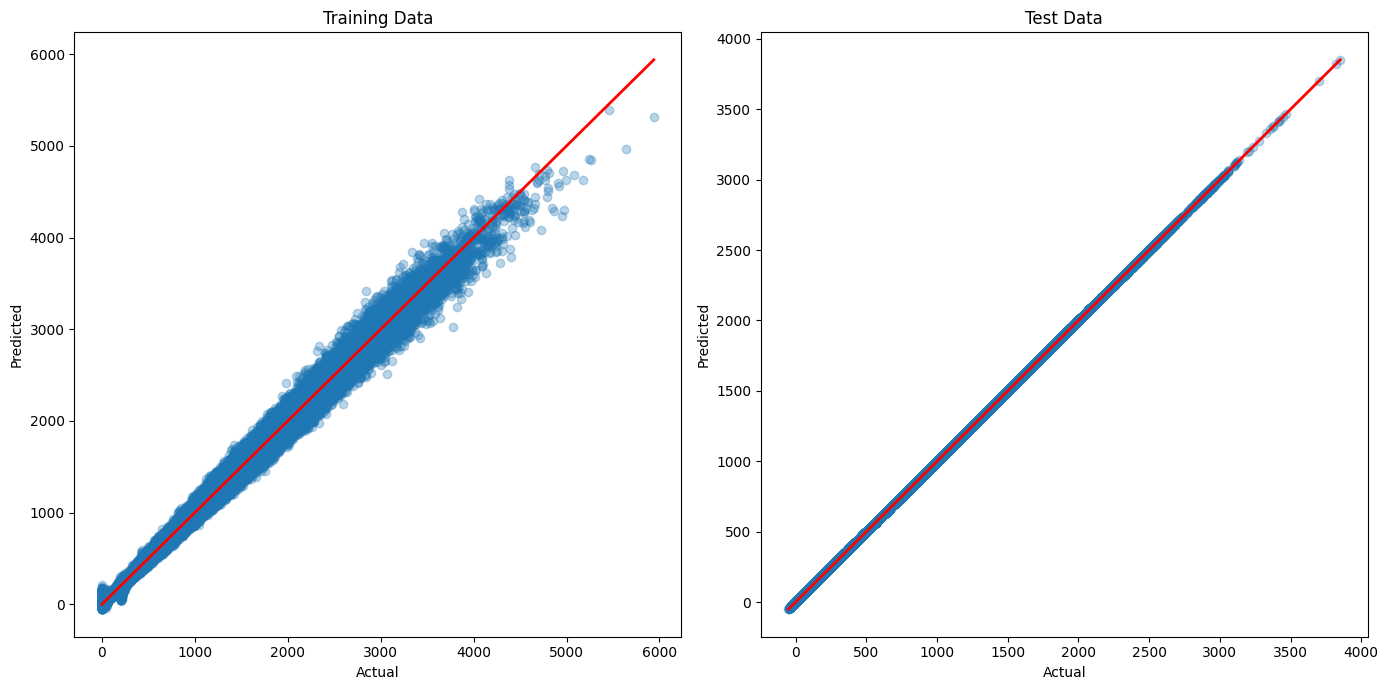

In [52]:
# Adding a cell for auditing final_model on train and test datasets

# Calculate predictions for both training and test datasets
train_predictions = final_model.predict(X).round().astype(int)
test_predictions = final_model.predict(X_test).round().astype(int)

# Calculate MAPE for training dataset
train_mape = mean_absolute_percentage_error(y, train_predictions)

# Calculate MAPE for test dataset
test_mape = mean_absolute_percentage_error(test_pd[target], test_predictions)

# Print the results
print(f"Training MAPE: {train_mape:.4f}")
print(f"Test MAPE: {test_mape:.4f}")

# You can also visualize the results if needed
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plotting training predictions
plt.subplot(1, 2, 1)
plt.scatter(y, train_predictions, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data')

# Plotting test predictions
plt.subplot(1, 2, 2)
plt.scatter(test_pd[target], test_predictions, alpha=0.3)
plt.plot([test_pd[target].min(), test_pd[target].max()], [test_pd[target].min(), test_pd[target].max()], 'r', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test Data')

plt.tight_layout()
plt.show()